In [1]:
import pandas as pd
from statsmodels.stats.contingency_tables import cochrans_q
import scipy.stats
import numpy as np
import scikit_posthocs as sp
import matplotlib.pyplot as plt
import matplotlib

In [2]:
THRESHOLD = 0.05 #alpha significance level
PREDICTIONS_DIR = 'predictions'

tasks = {
    'binary': [0, 1], 
    'type': [0, 1, 2, 3]
}
representations = ['bow', 'freq', 'tfidf']
models = ['decision-tree', 'svm', 'naive-bayes', 'xgboost']
methods = ['SMOTETomek', 'RandomOver', 'ADASYN', 'RandomUnder', 'none']

In [3]:
#find the mode of a numpy array
def mode(array):
    freq = np.bincount(array)
    return np.argmax(freq)

In [4]:
def shorten_name(name):
    shortenings = {
    'decision-tree': 'dt',
    'naive-bayes-multinomial': 'nbm',
    'naive-bayes': 'nb',
    'xgboost': 'xgb',
    '-classification': '',
    '-type_of_antisemitism': '',}
    for long_version in shortenings:
        name = name.replace(long_version, shortenings[long_version])
    return name

#visualize the results of a post-hoc dunn analysis on a cochran's q test using matplotlib in a matrix
def visualize_dunn(dunn_values, names):
    names = [shorten_name(name) for name in names]
    
    plt.matshow(dunn_values)
    ax = plt.gca()
    ax.xaxis.set_major_locator(matplotlib.ticker.FixedLocator(range(len(names))))
    ax.set_xticklabels(labels=names,rotation=90)
    ax.yaxis.set_major_locator(matplotlib.ticker.FixedLocator(range(len(names))))
    ax.set_yticklabels(labels=names)
    
    #pulled these next two lines from stack overflow, just to display the values
    for (i, j), z in np.ndenumerate(dunn_values):
        ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
        
    plt.pause(0.1)

In [5]:
#find the raw accuracy scores of all of the columns
def find_accuracy(df):
    accuracies = [1,]
    for column in [column for column in df.columns.values if column != 'Actual']:
        df[column] = df.apply(lambda x: int(x[column] == x['Actual']), axis=1)
        accuracies.append(df[column].mean())
    return accuracies

In [6]:
#combine columns in a dataframe whose names contain certain substrings
def combine_columns(df, substrings):
    '''
    df: the input dataframe that has many column names that contain certain common substrings
    substrings: the list of substrings used for combination
    
    returns: `output_df`, a DataFrame with `substrings` as its columns. Each row is the mode
    of the value for that row of all of the columns in `df` that contained that substring.
    '''
    output_df = pd.DataFrame()
    
    for column_substring in substrings:
        temp_df = pd.DataFrame()
        to_be_combined = [column for column in df.columns.values if column_substring in column]
        
        for column in to_be_combined:
            temp_df[column] = df[column]
            
        array = np.array(temp_df).astype(int)
        array = [mode(row) for row in array]
            
        output_df[column_substring] = array
    
    return output_df

In [7]:
#find which models performed best using basic accuracy score
def evaluate_models(df, substrings):
    output_df = pd.DataFrame()
    temp_df = combine_columns(df, substrings)
    for column in substrings:
        temp_df[column] = temp_df[column] == df['Actual']
        output_df[column] = [sum(temp_df[column])/len(temp_df),]
    output_df.index = ['Score']
    if 'index' in output_df.columns.values: del output_df['index']
    return output_df

#test model significance difference w/ Friedman Chi^2 while combining certain columns
def test_model_difference(df, substrings):
    df = combine_columns(df, substrings)
    columns = [df[substring] for substring in substrings]
    cochran_result = cochrans_q(columns)
    return cochran_result

def post_hoc_tests(df, substrings):
    df = combine_columns(df, substrings)
    columns = [df[substring] for substring in substrings]
    p_values = sp.posthoc_dunn(columns)
    return p_values

In [8]:
#get a list of binary dfs of whether or not they fit with a particular classification
def get_dfs(df, classifications):
    dfs = []
    for classification in classifications:
        temp_df = df[df['Actual'] == classification]
        temp_df = temp_df.reset_index()
        dfs.append(temp_df)
    return dfs

#find specific rankings for each model
def overall_evaluation(task, classifications, method):
    df = pd.read_csv(f'{PREDICTIONS_DIR}\\{task}_predictions-{method}.csv')
    score_df = pd.DataFrame()
    dfs = get_dfs(df, classifications)
        
    for (i, temp_df) in enumerate(dfs):
        temp_df = evaluate_models(temp_df, temp_df.columns.values).transpose()
        temp_df = temp_df.sort_values('Score', ascending=False)
            
        score_df[f'Score {i}'] = temp_df['Score']
    
    score_df['Mean score'] = score_df.mean(axis=1)
    score_df['Accuracy'] = find_accuracy(df)
    score_df = score_df.sort_values('Mean score', ascending = False)
    cochran_result = cochrans_q(df)
    post_hoc_p = pd.DataFrame()
    if cochran_result.pvalue <= THRESHOLD:
        post_hoc_p = post_hoc_tests(df, df.columns.values)
    
    print(f'Task: {task}.')
    print(f"Cochran's Q test p-value: {cochran_result.pvalue}")
    if cochran_result.pvalue <= THRESHOLD:
        print('Post-hoc Dunn test array:')
        visualize_dunn(post_hoc_p, df.columns.values)
    
    score_df.index = [shorten_name(name) for name in score_df.index]
    print(score_df)
    print(f'\nMean: {score_df["Mean score"].mean()}')
    print('\n\n')
    return score_df

In [9]:
def evaluate_rep_model(grouping, dfs):
    final_df = pd.DataFrame()
    
    for i, df in enumerate(dfs):
        temp_df = evaluate_models(df, grouping).transpose()
        temp_df = temp_df.sort_values('Score', ascending=False)
        
        temp_df.columns = ['Score']
        final_df[f'Score {i}'] = temp_df['Score']
        
    return final_df

#evaluate algorithms and representations, find significance level
def algorithm_and_rep_eval(task, classifications, method):
    df = pd.read_csv(f'{PREDICTIONS_DIR}\\{task}_predictions-{method}.csv')
    dfs = []
    for classification in classifications:
        temp_df = df[df['Actual'] == classification]
        temp_df = temp_df.reset_index()
        dfs.append(temp_df)
    for grouping in [representations, models]:
        score_df = evaluate_rep_model(grouping, dfs)
        score_df['Mean score'] = score_df.mean(axis=1)
        score_df = score_df.sort_values('Mean score', ascending = False)
        
        combined_df = combine_columns(df, grouping)
        cochran_result = cochrans_q(combined_df)
        if cochran_result.pvalue <= THRESHOLD:
            post_hoc_p = post_hoc_tests(combined_df, grouping)
        
        print(f'Task: {task}. Grouping: {grouping}.')
        print(f"Cochran's Q test p-value: {cochran_result.pvalue}")
        if cochran_result.pvalue <= THRESHOLD:
            print('Post-hoc Dunn test array:')
            visualize_dunn(post_hoc_p, grouping)
        
        score_df.index = [shorten_name(name) for name in score_df.index]
        print(f"Scores: \n{score_df}")
        print(f'\nMean: {score_df["Mean score"].mean()}')
        print('\n\n')

In [10]:
#evaluate the overall resampling methods, perform friedman test and post-hoc nemenyi
def evaluate_resampling(overall_df, indeces):
    columns = [overall_df[column] for column in overall_df.columns.values]
    statistic, pvalue = scipy.stats.friedmanchisquare(*columns)
    overall_df.loc[len(overall_df)] = overall_df.apply(lambda x: np.mean(x))
    indeces.append('Mean')
    overall_df.index = indeces
    print('\nOverall scores:')
    print(f'Friedman Chi Square Statistic: {statistic}. p-value: {pvalue}.')
    print(overall_df)
    if pvalue <= THRESHOLD:
        overall_df = overall_df.transpose()
        columns = [overall_df[column] for column in overall_df.columns.values]
        p_values = sp.posthoc_nemenyi_friedman(columns)
        print('\nPost-hoc Dunn test array:')
        visualize_dunn(p_values, list(overall_df.index))

The below visualizations and `DataFrame`s contain testing information on the various algorithms and representation methods used to create models. Data is shown on two tasks, 'binary,' referring to the binary classification of whether or not a particular tweet is antisemitic, and 'type,' referring to classifying the tweet with a particular type of antisemitism. The model evaluation was done in two stages, first the overall evaluation, then the grouped evaluation for different algorithms and representations. Some names are shortened during presentation: `decision-tree` is shortened to `dt`, `naive-bayes-multinomial` to `nbm`, and `naive-bayes` to `nb`.

For the overall evaluation, the model scores were generated using the arithmetic mean of the recalls on each individual class, with a Cochran's Q test being performed on a matrix that contained columns for each model and in each column contained a `1` where the model found the correct answer, and `0` where the model found the incorrect answer. Then, if the Q test found an *p*-value lower than the specified global `THRESHOLD` constant, it performs a post-hoc Dunn text, which is then visualized in the form of a matrix, with higher values meaning lighter colors and a greater correlation between two models' answers. Then, the score `DataFrame` is shown, with a column entitled `Mean score` for the arithmetic mean of the recall of the model on each class. There are additional columns entitles `Score {x}`, with `{x}` being the specific class that that column gives the recall of for each model. Finally, an overall mean of the `Mean score` column is given.

For the model grouping evaluation, models are grouped into classes either by their representation or algorithm type. The most common answer across all models of this type is then taken as the answer for this grouping. Following this, the same process as above was used.

In [11]:
def task_eval(task):
    print(f'\nTask: {task.title()}\n')
    overall_df = pd.DataFrame()
    indeces = []
    for method in methods:
        print(f'\nMethod: {method}\n')
        temp_df = overall_evaluation(task, tasks[task], method) #find the rankings for all models
        if not indeces:
            indeces = list(temp_df.index)
        overall_df[method] = temp_df['Mean score']
        algorithm_and_rep_eval(task, tasks[task], method) #group representations and algorithms together, evaluate
    evaluate_resampling(overall_df, indeces)


Task: Binary


Method: SMOTETomek

Task: binary.
Cochran's Q test p-value: 0.0
Post-hoc Dunn test array:


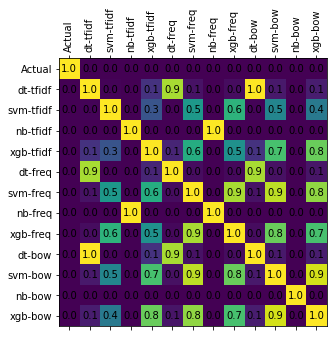

            Score 0   Score 1  Mean score  Accuracy
Actual     1.000000  1.000000    1.000000  1.000000
xgb-bow    0.773973  0.566860    0.670417  0.722951
svm-tfidf  0.824201  0.497093    0.660647  0.681148
svm-bow    0.791096  0.529070    0.660083  0.719672
svm-freq   0.796804  0.523256    0.660030  0.709836
xgb-freq   0.808219  0.505814    0.657017  0.731967
xgb-tfidf  0.801370  0.476744    0.639057  0.427869
dt-bow     0.742009  0.526163    0.634086  0.681148
dt-freq    0.781963  0.412791    0.597377  0.427869
dt-tfidf   0.794521  0.392442    0.593481  0.677869
nb-bow     0.462329  0.622093    0.542211  0.717213
nb-tfidf   0.280822  0.802326    0.541574  0.715574
nb-freq    0.288813  0.781977    0.535395  0.507377

Mean: 0.6454902549399205



Task: binary. Grouping: ['bow', 'freq', 'tfidf'].
Cochran's Q test p-value: 0.00010473029437284162
Post-hoc Dunn test array:


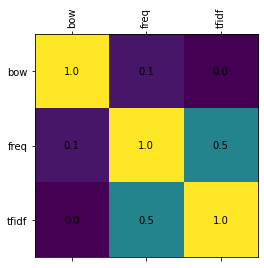

Scores: 
        Score 0   Score 1  Mean score
bow    0.810502  0.500000    0.655251
freq   0.836758  0.453488    0.645123
tfidf  0.844749  0.427326    0.636037

Mean: 0.6454705143180773



Task: binary. Grouping: ['decision-tree', 'svm', 'naive-bayes', 'xgboost'].
Cochran's Q test p-value: 6.746824059699358e-259
Post-hoc Dunn test array:


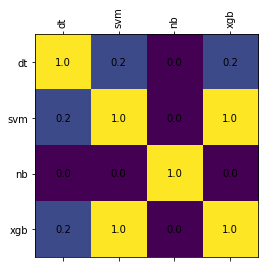

Scores: 
      Score 0   Score 1  Mean score
svm  0.823059  0.505814    0.664437
xgb  0.821918  0.502907    0.662412
dt   0.812785  0.395349    0.604067
nb   0.291096  0.790698    0.540897

Mean: 0.6179532361686312




Method: RandomOver

Task: binary.
Cochran's Q test p-value: 0.0
Post-hoc Dunn test array:


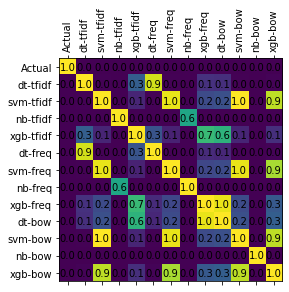

            Score 0   Score 1  Mean score  Accuracy
Actual     1.000000  1.000000    1.000000  1.000000
svm-bow    0.772831  0.590116    0.681474  0.722131
xgb-bow    0.787671  0.543605    0.665638  0.441803
svm-freq   0.805936  0.508721    0.657329  0.721311
dt-bow     0.757991  0.546512    0.652251  0.698361
svm-tfidf  0.812785  0.488372    0.650579  0.668852
xgb-freq   0.783105  0.479651    0.631378  0.689344
xgb-tfidf  0.771689  0.479651    0.625670  0.697541
nb-bow     0.558219  0.686047    0.622133  0.721311
dt-tfidf   0.771689  0.406977    0.589333  0.431148
dt-freq    0.772831  0.398256    0.585543  0.667213
nb-tfidf   0.302511  0.796512    0.549512  0.594262
nb-freq    0.292237  0.784884    0.538561  0.718852

Mean: 0.6499538477875528



Task: binary. Grouping: ['bow', 'freq', 'tfidf'].
Cochran's Q test p-value: 0.0027287419757207206
Post-hoc Dunn test array:


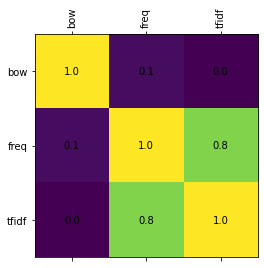

Scores: 
        Score 0   Score 1  Mean score
bow    0.812785  0.537791    0.675288
tfidf  0.829909  0.456395    0.643152
freq   0.824201  0.456395    0.640298

Mean: 0.6529127287529645



Task: binary. Grouping: ['decision-tree', 'svm', 'naive-bayes', 'xgboost'].
Cochran's Q test p-value: 9.847513220981397e-227
Post-hoc Dunn test array:


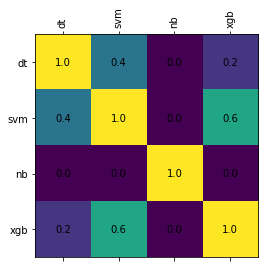

Scores: 
      Score 0   Score 1  Mean score
svm  0.809361  0.508721    0.659041
xgb  0.787671  0.491279    0.639475
dt   0.796804  0.415698    0.606251
nb   0.308219  0.787791    0.548005

Mean: 0.6131928958266963




Method: ADASYN

Task: binary.
Cochran's Q test p-value: 0.0
Post-hoc Dunn test array:


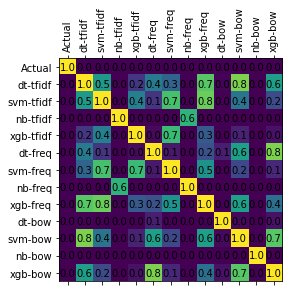

            Score 0   Score 1  Mean score  Accuracy
Actual     1.000000  1.000000    1.000000  1.000000
svm-tfidf  0.736301  0.598837    0.667569  0.704918
svm-freq   0.760274  0.563953    0.662114  0.713115
svm-bow    0.715753  0.590116    0.652935  0.418033
xgb-bow    0.706621  0.590116    0.648369  0.691803
xgb-tfidf  0.799087  0.494186    0.646636  0.685246
xgb-freq   0.760274  0.517442    0.638858  0.668852
dt-bow     0.650685  0.593023    0.621854  0.634426
dt-tfidf   0.797945  0.398256    0.598101  0.697541
dt-freq    0.783105  0.377907    0.580506  0.409016
nb-bow     0.452055  0.630814    0.541434  0.680328
nb-freq    0.270548  0.793605    0.532076  0.502459
nb-tfidf   0.257991  0.793605    0.525798  0.673770

Mean: 0.6397115282508721



Task: binary. Grouping: ['bow', 'freq', 'tfidf'].
Cochran's Q test p-value: 1.1041197870965935e-14
Post-hoc Dunn test array:


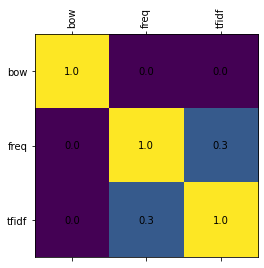

Scores: 
        Score 0   Score 1  Mean score
tfidf  0.831050  0.459302    0.645176
bow    0.735160  0.552326    0.643743
freq   0.809361  0.473837    0.641599

Mean: 0.6435059820891297



Task: binary. Grouping: ['decision-tree', 'svm', 'naive-bayes', 'xgboost'].
Cochran's Q test p-value: 5.2375751734307385e-230
Post-hoc Dunn test array:


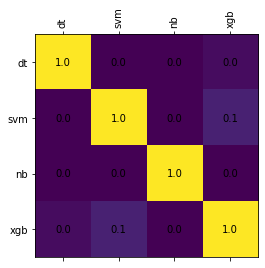

Scores: 
      Score 0   Score 1  Mean score
svm  0.765982  0.584302    0.675142
xgb  0.793379  0.534884    0.664131
dt   0.800228  0.401163    0.600696
nb   0.278539  0.793605    0.536072

Mean: 0.6190101677816715




Method: RandomUnder

Task: binary.
Cochran's Q test p-value: 9.624842138114793e-251
Post-hoc Dunn test array:


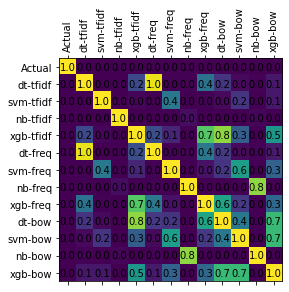

            Score 0   Score 1  Mean score  Accuracy
Actual     1.000000  1.000000    1.000000  1.000000
svm-bow    0.707763  0.671512    0.689637  0.557377
xgb-bow    0.705479  0.648256    0.676868  0.654098
dt-bow     0.703196  0.625000    0.664098  0.709016
svm-tfidf  0.817352  0.491279    0.654315  0.653279
xgb-tfidf  0.706621  0.601744    0.654183  0.677049
xgb-freq   0.694064  0.610465    0.652265  0.670492
svm-freq   0.789954  0.502907    0.646431  0.725410
dt-freq    0.687215  0.569767    0.628491  0.681148
nb-bow     0.571918  0.683140    0.627529  0.603279
dt-tfidf   0.698630  0.537791    0.618210  0.599180
nb-freq    0.587900  0.627907    0.607903  0.697541
nb-tfidf   0.507991  0.683140    0.595565  0.689344

Mean: 0.6704226603278849



Task: binary. Grouping: ['bow', 'freq', 'tfidf'].
Cochran's Q test p-value: 2.5511596791051966e-07
Post-hoc Dunn test array:


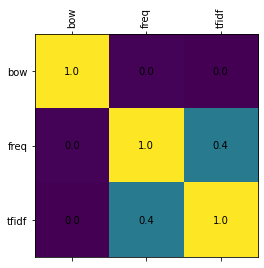

Scores: 
        Score 0   Score 1  Mean score
bow    0.739726  0.619186    0.679456
tfidf  0.793379  0.526163    0.659771
freq   0.775114  0.534884    0.654999

Mean: 0.6647419560369544



Task: binary. Grouping: ['decision-tree', 'svm', 'naive-bayes', 'xgboost'].
Cochran's Q test p-value: 6.282148502565895e-57
Post-hoc Dunn test array:


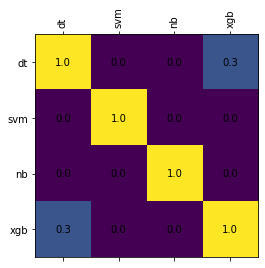

Scores: 
      Score 0   Score 1  Mean score
xgb  0.706621  0.619186    0.662904
svm  0.797945  0.520349    0.659147
dt   0.721461  0.578488    0.649975
nb   0.553653  0.680233    0.616943

Mean: 0.6472420224062865




Method: none

Task: binary.
Cochran's Q test p-value: 0.0
Post-hoc Dunn test array:


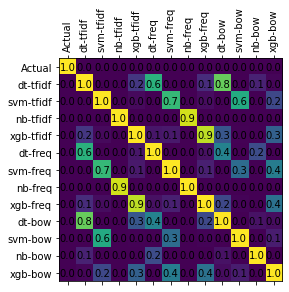

            Score 0   Score 1  Mean score  Accuracy
Actual     1.000000  1.000000    1.000000  1.000000
svm-bow    0.918950  0.415698    0.667324  0.474590
xgb-bow    0.871005  0.418605    0.644805  0.723770
nb-bow     0.704338  0.563953    0.634146  0.777049
svm-tfidf  0.940639  0.325581    0.633110  0.767213
xgb-freq   0.863014  0.377907    0.620460  0.759016
dt-bow     0.810502  0.427326    0.618914  0.702459
xgb-tfidf  0.864155  0.366279    0.615217  0.687705
svm-freq   0.949772  0.273256    0.611514  0.696721
dt-tfidf   0.823059  0.375000    0.599030  0.472951
dt-freq    0.813927  0.366279    0.590103  0.726230
nb-tfidf   0.361872  0.761628    0.561750  0.664754
nb-freq    0.359589  0.761628    0.560608  0.743443

Mean: 0.6428446712573823



Task: binary. Grouping: ['bow', 'freq', 'tfidf'].
Cochran's Q test p-value: 0.00029139084837138637
Post-hoc Dunn test array:


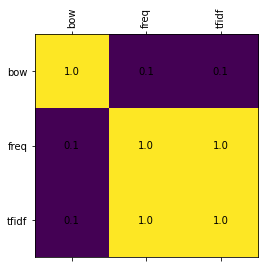

Scores: 
        Score 0   Score 1  Mean score
bow    0.901826  0.404070    0.652948
tfidf  0.909817  0.325581    0.617699
freq   0.905251  0.313953    0.609602

Mean: 0.6267499380552901



Task: binary. Grouping: ['decision-tree', 'svm', 'naive-bayes', 'xgboost'].
Cochran's Q test p-value: 3.622480978298441e-280
Post-hoc Dunn test array:


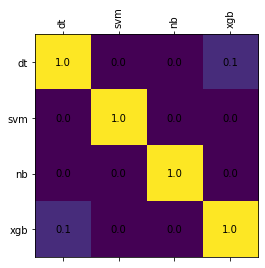

Scores: 
      Score 0   Score 1  Mean score
svm  0.942922  0.325581    0.634252
xgb  0.863014  0.369186    0.616100
dt   0.821918  0.366279    0.594098
nb   0.361872  0.761628    0.561750

Mean: 0.6015500557502389




Overall scores:
Friedman Chi Square Statistic: 13.46666666666668. p-value: 0.009206980401514932.
           SMOTETomek  RandomOver    ADASYN  RandomUnder      none
Actual       1.000000    1.000000  1.000000     1.000000  1.000000
xgb-bow      0.670417    0.665638  0.648369     0.676868  0.644805
svm-tfidf    0.660647    0.650579  0.667569     0.654315  0.633110
svm-bow      0.660083    0.681474  0.652935     0.689637  0.667324
svm-freq     0.660030    0.657329  0.662114     0.646431  0.611514
xgb-freq     0.657017    0.631378  0.638858     0.652265  0.620460
xgb-tfidf    0.639057    0.625670  0.646636     0.654183  0.615217
dt-bow       0.634086    0.652251  0.621854     0.664098  0.618914
dt-freq      0.597377    0.585543  0.580506     0.628491  0.590103
dt-tfidf     0

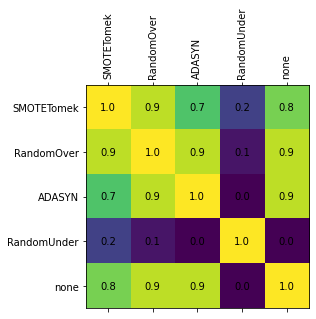

In [12]:
task_eval('binary')


Task: Type


Method: SMOTETomek

Task: type.
Cochran's Q test p-value: 5.684879652185987e-309
Post-hoc Dunn test array:


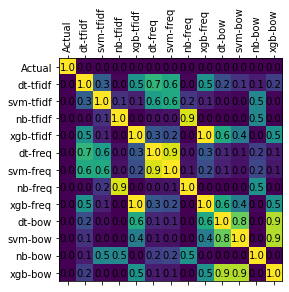

            Score 0  Score 1   Score 2   Score 3  Mean score  Accuracy
Actual     1.000000    1.000  1.000000  1.000000    1.000000  1.000000
nb-bow     0.500000    0.500  0.564103  0.130081    0.423546  0.373529
dt-bow     0.570588    0.125  0.564103  0.382114    0.410451  0.426471
svm-bow    0.600000    0.125  0.487179  0.398374    0.402638  0.444118
xgb-bow    0.576471    0.125  0.461538  0.422764    0.396443  0.344118
svm-tfidf  0.488235    0.000  0.794872  0.186992    0.367525  0.497059
xgb-tfidf  0.552941    0.000  0.538462  0.365854    0.364314  0.347059
svm-freq   0.535294    0.000  0.666667  0.219512    0.355368  0.470588
xgb-freq   0.594118    0.000  0.487179  0.325203    0.351625  0.402941
dt-tfidf   0.552941    0.000  0.538462  0.292683    0.346021  0.423529
nb-freq    0.523529    0.375  0.307692  0.113821    0.330011  0.502941
nb-tfidf   0.523529    0.375  0.230769  0.130081    0.314845  0.491176
dt-freq    0.570588    0.000  0.435897  0.252033    0.314630  0.470588

Mean:

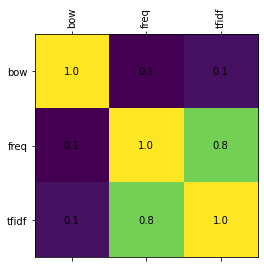

Scores: 
        Score 0  Score 1   Score 2   Score 3  Mean score
bow    0.623529    0.125  0.512821  0.357724    0.404768
freq   0.641176    0.000  0.589744  0.243902    0.368706
tfidf  0.600000    0.000  0.615385  0.219512    0.358724

Mean: 0.3773994009736477



Task: type. Grouping: ['decision-tree', 'svm', 'naive-bayes', 'xgboost'].
Cochran's Q test p-value: 2.0313875576987643e-12
Post-hoc Dunn test array:


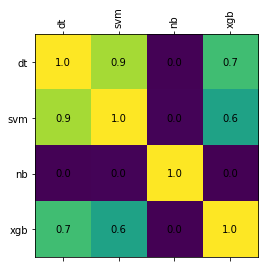

Scores: 
      Score 0  Score 1   Score 2   Score 3  Mean score
svm  0.576471    0.000  0.692308  0.227642    0.374105
xgb  0.576471    0.000  0.512821  0.325203    0.353624
dt   0.576471    0.000  0.512821  0.252033    0.335331
nb   0.535294    0.375  0.307692  0.105691    0.330919

Mean: 0.34849475085531395




Method: RandomOver

Task: type.
Cochran's Q test p-value: 5.684879652185987e-309
Post-hoc Dunn test array:


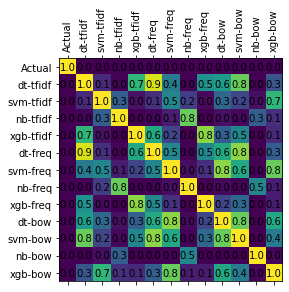

            Score 0  Score 1   Score 2   Score 3  Mean score  Accuracy
Actual     1.000000    1.000  1.000000  1.000000    1.000000  1.000000
svm-bow    0.588235    0.250  0.641026  0.186992    0.416563  0.452941
xgb-bow    0.517647    0.375  0.538462  0.219512    0.412655  0.441176
dt-bow     0.552941    0.250  0.589744  0.219512    0.403049  0.450000
svm-tfidf  0.447059    0.125  0.820513  0.195122    0.396923  0.308824
xgb-freq   0.552941    0.000  0.487179  0.406504    0.361656  0.470588
xgb-tfidf  0.564706    0.000  0.487179  0.365854    0.354435  0.391176
svm-freq   0.529412    0.000  0.641026  0.227642    0.349520  0.338235
dt-tfidf   0.552941    0.000  0.461538  0.341463    0.338986  0.350000
nb-bow     0.447059    0.500  0.282051  0.113821    0.335733  0.408824
nb-tfidf   0.517647    0.375  0.307692  0.130081    0.332605  0.479412
nb-freq    0.517647    0.375  0.307692  0.097561    0.324475  0.429412
dt-freq    0.547059    0.000  0.307692  0.390244    0.311249  0.420588

Mean:

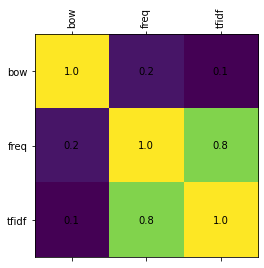

Scores: 
        Score 0  Score 1   Score 2   Score 3  Mean score
bow    0.594118     0.25  0.564103  0.186992    0.398803
tfidf  0.611765     0.00  0.564103  0.260163    0.359007
freq   0.605882     0.00  0.435897  0.292683    0.333616

Mean: 0.36380872236324174



Task: type. Grouping: ['decision-tree', 'svm', 'naive-bayes', 'xgboost'].
Cochran's Q test p-value: 1.9115298225607485e-20
Post-hoc Dunn test array:


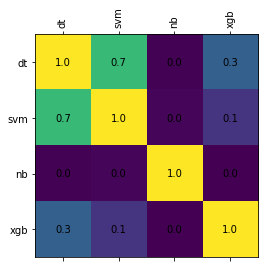

Scores: 
      Score 0  Score 1   Score 2   Score 3  Mean score
svm  0.564706    0.125  0.692308  0.203252    0.396316
xgb  0.564706    0.000  0.512821  0.357724    0.358812
nb   0.523529    0.375  0.307692  0.097561    0.325946
dt   0.570588    0.000  0.384615  0.317073    0.318069

Mean: 0.3497859415811353




Method: ADASYN

Task: type.
Cochran's Q test p-value: 5.684879652185987e-309
Post-hoc Dunn test array:


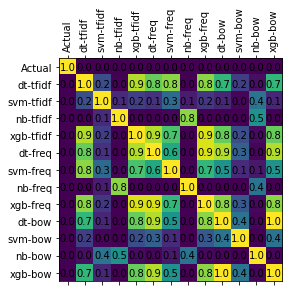

            Score 0  Score 1   Score 2   Score 3  Mean score  Accuracy
Actual     1.000000    1.000  1.000000  1.000000    1.000000  1.000000
nb-bow     0.476471    0.500  0.794872  0.113821    0.471291  0.482353
dt-bow     0.682353    0.125  0.282051  0.292683    0.345522  0.417647
xgb-bow    0.641176    0.125  0.256410  0.357724    0.345078  0.473529
nb-tfidf   0.535294    0.375  0.307692  0.121951    0.334984  0.517647
nb-freq    0.535294    0.375  0.307692  0.097561    0.328887  0.382353
svm-bow    0.735294    0.125  0.025641  0.398374    0.321077  0.464706
dt-freq    0.658824    0.000  0.307692  0.308943    0.318865  0.355882
xgb-tfidf  0.647059    0.000  0.230769  0.333333    0.302790  0.455882
dt-tfidf   0.652941    0.000  0.256410  0.300813    0.302541  0.476471
xgb-freq   0.647059    0.000  0.205128  0.349593    0.300445  0.347059
svm-tfidf  0.552941    0.125  0.000000  0.382114    0.265014  0.482353
svm-freq   0.658824    0.000  0.000000  0.349593    0.252104  0.470588

Mean:

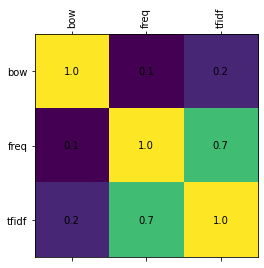

Scores: 
        Score 0  Score 1   Score 2   Score 3  Mean score
bow    0.705882    0.125  0.282051  0.300813    0.353437
freq   0.717647    0.000  0.282051  0.252033    0.312933
tfidf  0.700000    0.000  0.282051  0.268293    0.312586

Mean: 0.32631845577505547



Task: type. Grouping: ['decision-tree', 'svm', 'naive-bayes', 'xgboost'].
Cochran's Q test p-value: 1.0556929244671439e-13
Post-hoc Dunn test array:


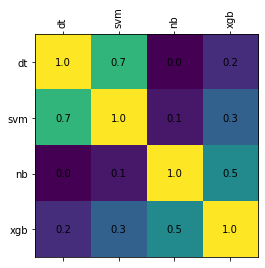

Scores: 
      Score 0  Score 1   Score 2   Score 3  Mean score
nb   0.541176    0.375  0.307692  0.097561    0.330357
dt   0.688235    0.000  0.282051  0.292683    0.315742
xgb  0.658824    0.000  0.230769  0.349593    0.309797
svm  0.664706    0.000  0.000000  0.341463    0.251542

Mean: 0.3018596756244712




Method: RandomUnder

Task: type.
Cochran's Q test p-value: 5.684879652185987e-309
Post-hoc Dunn test array:


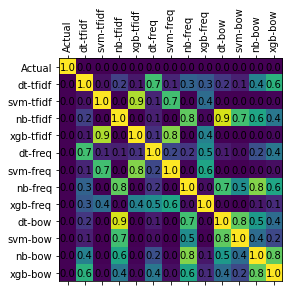

            Score 0  Score 1   Score 2   Score 3  Mean score  Accuracy
Actual     1.000000    1.000  1.000000  1.000000    1.000000  1.000000
xgb-tfidf  0.200000    0.750  0.384615  0.260163    0.398694  0.344118
nb-tfidf   0.352941    0.125  0.666667  0.333333    0.369485  0.364706
dt-tfidf   0.300000    0.250  0.538462  0.300813    0.347319  0.285294
dt-bow     0.552941    0.250  0.410256  0.138211    0.337852  0.326471
svm-freq   0.276471    0.375  0.487179  0.170732    0.327345  0.391176
svm-tfidf  0.229412    0.375  0.512821  0.186992    0.326056  0.355882
xgb-freq   0.288235    0.375  0.384615  0.243902    0.322938  0.379412
nb-bow     0.429412    0.125  0.487179  0.227642    0.317308  0.311765
svm-bow    0.552941    0.125  0.410256  0.178862    0.316765  0.250000
xgb-bow    0.441176    0.125  0.487179  0.178862    0.308054  0.376471
nb-freq    0.435294    0.125  0.282051  0.308943    0.287822  0.255882
dt-freq    0.358824    0.125  0.435897  0.219512    0.284808  0.264706

Mean:

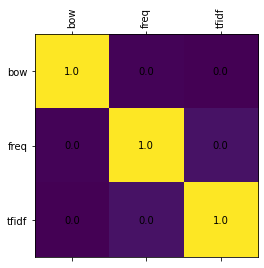

Scores: 
        Score 0  Score 1   Score 2   Score 3  Mean score
tfidf  0.347059    0.375  0.641026  0.227642    0.397682
bow    0.594118    0.125  0.487179  0.130081    0.334095
freq   0.458824    0.250  0.435897  0.178862    0.330896

Mean: 0.35422399416301853



Task: type. Grouping: ['decision-tree', 'svm', 'naive-bayes', 'xgboost'].
Cochran's Q test p-value: 1.7356651904833323e-08
Post-hoc Dunn test array:


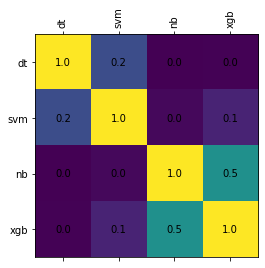

Scores: 
      Score 0  Score 1   Score 2   Score 3  Mean score
xgb  0.476471    0.500  0.307692  0.186992    0.367789
dt   0.605882    0.250  0.461538  0.146341    0.365941
svm  0.535294    0.375  0.410256  0.113821    0.358593
nb   0.517647    0.125  0.461538  0.195122    0.324827

Mean: 0.354287261339808




Method: none

Task: type.
Cochran's Q test p-value: 5.684879652185987e-309
Post-hoc Dunn test array:


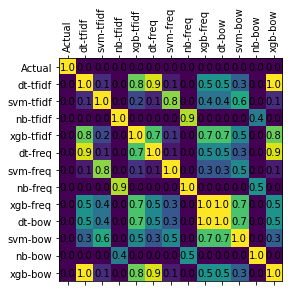

            Score 0  Score 1   Score 2   Score 3  Mean score  Accuracy
Actual     1.000000    1.000  1.000000  1.000000    1.000000  1.000000
dt-bow     0.729412    0.000  0.333333  0.325203    0.346987  0.505882
nb-bow     0.458824    0.500  0.307692  0.105691    0.343052  0.494118
xgb-tfidf  0.688235    0.000  0.282051  0.357724    0.332003  0.520588
xgb-freq   0.705882    0.000  0.230769  0.390244    0.331724  0.491176
nb-tfidf   0.517647    0.375  0.307692  0.121951    0.330573  0.314706
nb-freq    0.523529    0.375  0.307692  0.097561    0.325946  0.535294
xgb-bow    0.670588    0.000  0.256410  0.357724    0.321181  0.520588
dt-freq    0.694118    0.000  0.256410  0.317073    0.316900  0.341176
dt-tfidf   0.694118    0.000  0.230769  0.333333    0.314555  0.564706
svm-freq   0.829412    0.000  0.000000  0.414634    0.311011  0.494118
svm-tfidf  0.800000    0.000  0.000000  0.430894    0.307724  0.555882
svm-bow    0.758824    0.000  0.025641  0.422764    0.301807  0.347059

Mean:

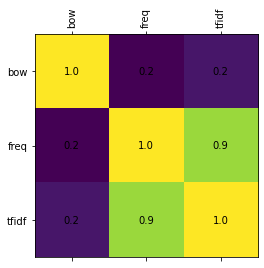

Scores: 
        Score 0  Score 1   Score 2   Score 3  Mean score
tfidf  0.782353      0.0  0.307692  0.300813    0.347715
bow    0.758824      0.0  0.282051  0.333333    0.343552
freq   0.800000      0.0  0.256410  0.300813    0.339306

Mean: 0.3435241388612981



Task: type. Grouping: ['decision-tree', 'svm', 'naive-bayes', 'xgboost'].
Cochran's Q test p-value: 5.801143385002869e-17
Post-hoc Dunn test array:


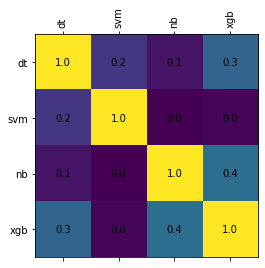

Scores: 
      Score 0  Score 1   Score 2   Score 3  Mean score
xgb  0.694118    0.000  0.256410  0.373984    0.331128
nb   0.529412    0.375  0.307692  0.097561    0.327416
dt   0.717647    0.000  0.230769  0.333333    0.320437
svm  0.829412    0.000  0.000000  0.398374    0.306946

Mean: 0.32148200391788984




Overall scores:
Friedman Chi Square Statistic: 9.33333333333336. p-value: 0.05328685445847224.
           SMOTETomek  RandomOver    ADASYN  RandomUnder      none
Actual       1.000000    1.000000  1.000000     1.000000  1.000000
nb-bow       0.423546    0.335733  0.471291     0.317308  0.343052
dt-bow       0.410451    0.403049  0.345522     0.337852  0.346987
svm-bow      0.402638    0.416563  0.321077     0.316765  0.301807
xgb-bow      0.396443    0.412655  0.345078     0.308054  0.321181
svm-tfidf    0.367525    0.396923  0.265014     0.326056  0.307724
xgb-tfidf    0.364314    0.354435  0.302790     0.398694  0.332003
svm-freq     0.355368    0.349520  0.252104     0.3273

In [13]:
task_eval('type')

Task: binary.
Cochran's Q test p-value: 7.637624767995486e-174
Post-hoc Dunn test array:


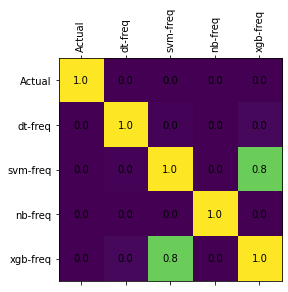

           Score 0   Score 1  Mean score  Accuracy
Actual    1.000000  1.000000    1.000000  1.000000
xgb-freq  0.802511  0.497093    0.649802  0.722131
svm-freq  0.826484  0.456395    0.641440  0.669672
dt-freq   0.738584  0.494186    0.616385  0.459016
nb-freq   0.304795  0.851744    0.578269  0.716393

Mean: 0.6971793033874908



Task: type.
Cochran's Q test p-value: 3.599601342021496e-105
Post-hoc Dunn test array:


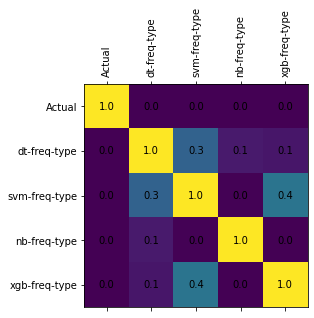

                Score 0  Score 1   Score 2   Score 3  Mean score  Accuracy
Actual         1.000000    1.000  1.000000  1.000000    1.000000  1.000000
xgb-freq-type  0.635294    0.500  0.512821  0.479675    0.531947  0.523529
dt-freq-type   0.476471    0.500  0.615385  0.439024    0.507720  0.400000
svm-freq-type  0.652941    0.000  0.589744  0.357724    0.400102  0.479412
nb-freq-type   0.423529    0.125  0.461538  0.365854    0.343980  0.561765

Mean: 0.5567499448184527





,Score 0,Score 1,Score 2,Score 3,Mean score,Accuracy
Actual,1.000000,1.000,1.000000,1.000000,1.000000,1.000000
xgb-freq-type,0.635294,0.500,0.512821,0.479675,0.531947,0.523529
dt-freq-type,0.476471,0.500,0.615385,0.439024,0.507720,0.400000
svm-freq-type,0.652941,0.000,0.589744,0.357724,0.400102,0.479412
nb-freq-type,0.423529,0.125,0.461538,0.365854,0.343980,0.561765


In [14]:
overall_evaluation('binary', tasks['binary'], 'aug') #find the rankings for augmented data
overall_evaluation('type', tasks['type'], 'aug') #find the rankings for augmented data